# Sampling Distributions

Good tool to have. Of course, the first way is the easiest

## Using Scipy

`rvs` is all you need

In [1]:
from scipy.stats import norm, uniform
from scipy.integrate import simps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


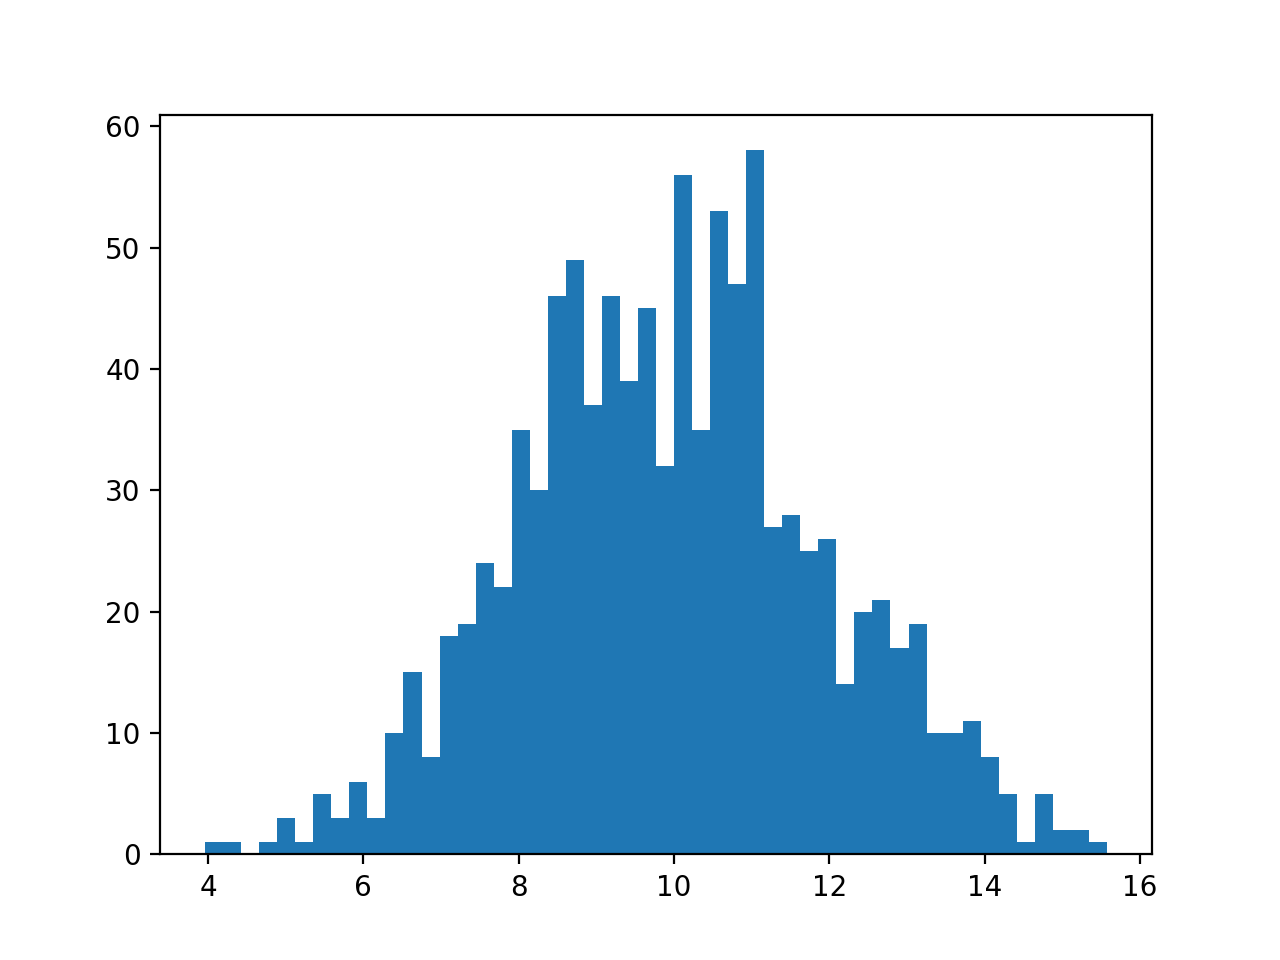

In [2]:
plt.hist(norm.rvs(loc=10, scale=2, size=1000), bins=50);

<IPython.core.display.Javascript object>


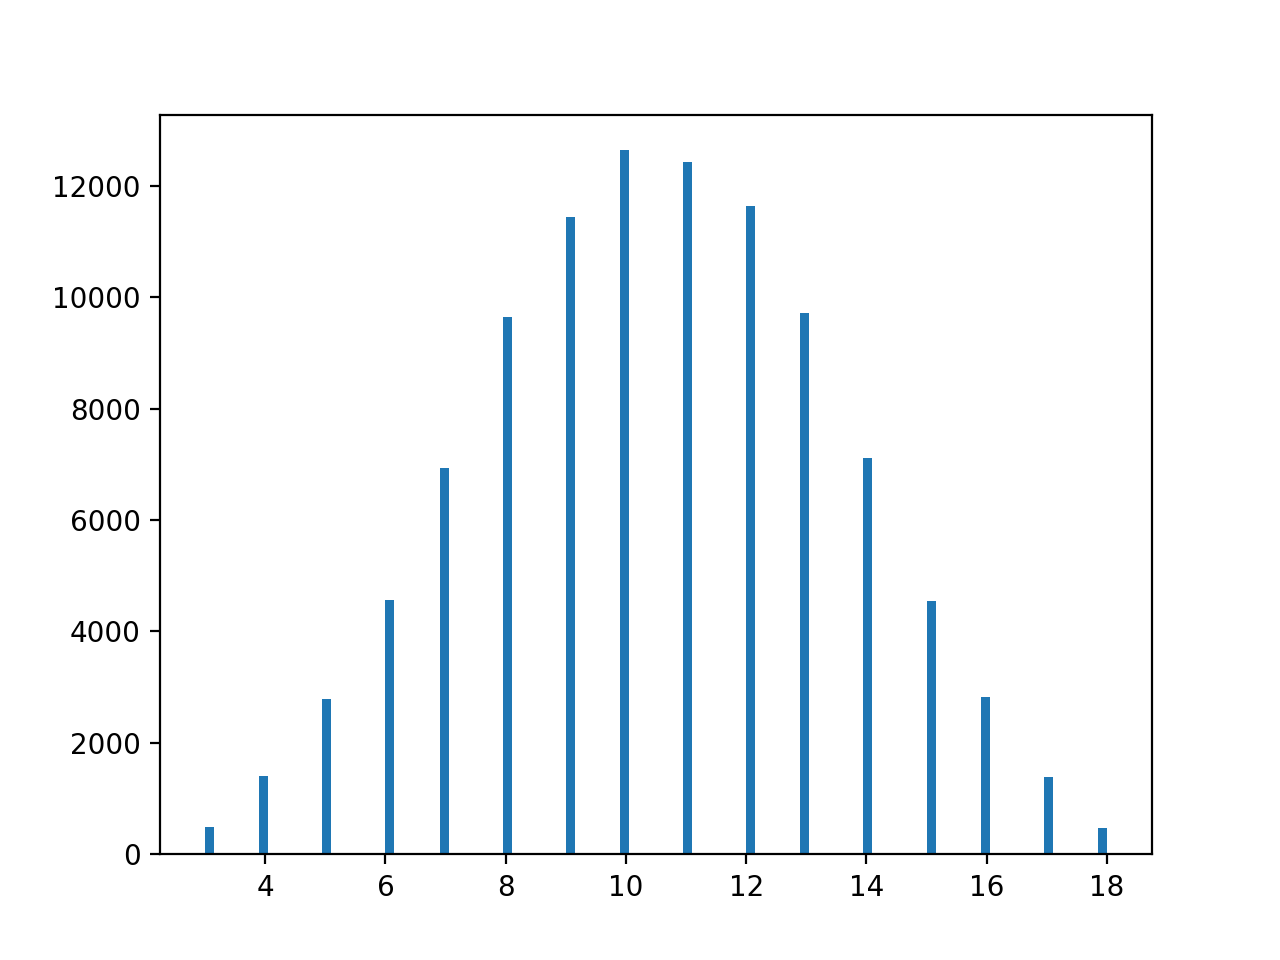

In [4]:
samples = np.ceil(uniform.rvs(loc=0, scale=6, size=(100000, 3))).sum(axis=1)
plt.hist(samples, bins=100);

### Rejection Sampling

Let us say we don't have a nice easy analytic distribution, and that we cannot use one to approximate our distribution. We can brute force our sampling by sampling the uniform distribution and just throwing away points. It works like this:

1. Sample a uniform `x` value
2. Sample a uniform `y` value from `0` to the maximum probability in your PDF
3. If $y > p(x)$, throw out the point.

Easier to see in practise. Lets try and sample from the *unnormalised* distribution $p(x) = \sin(x^2) + 1$ from $0 \rightarrow 4$ 

<IPython.core.display.Javascript object>


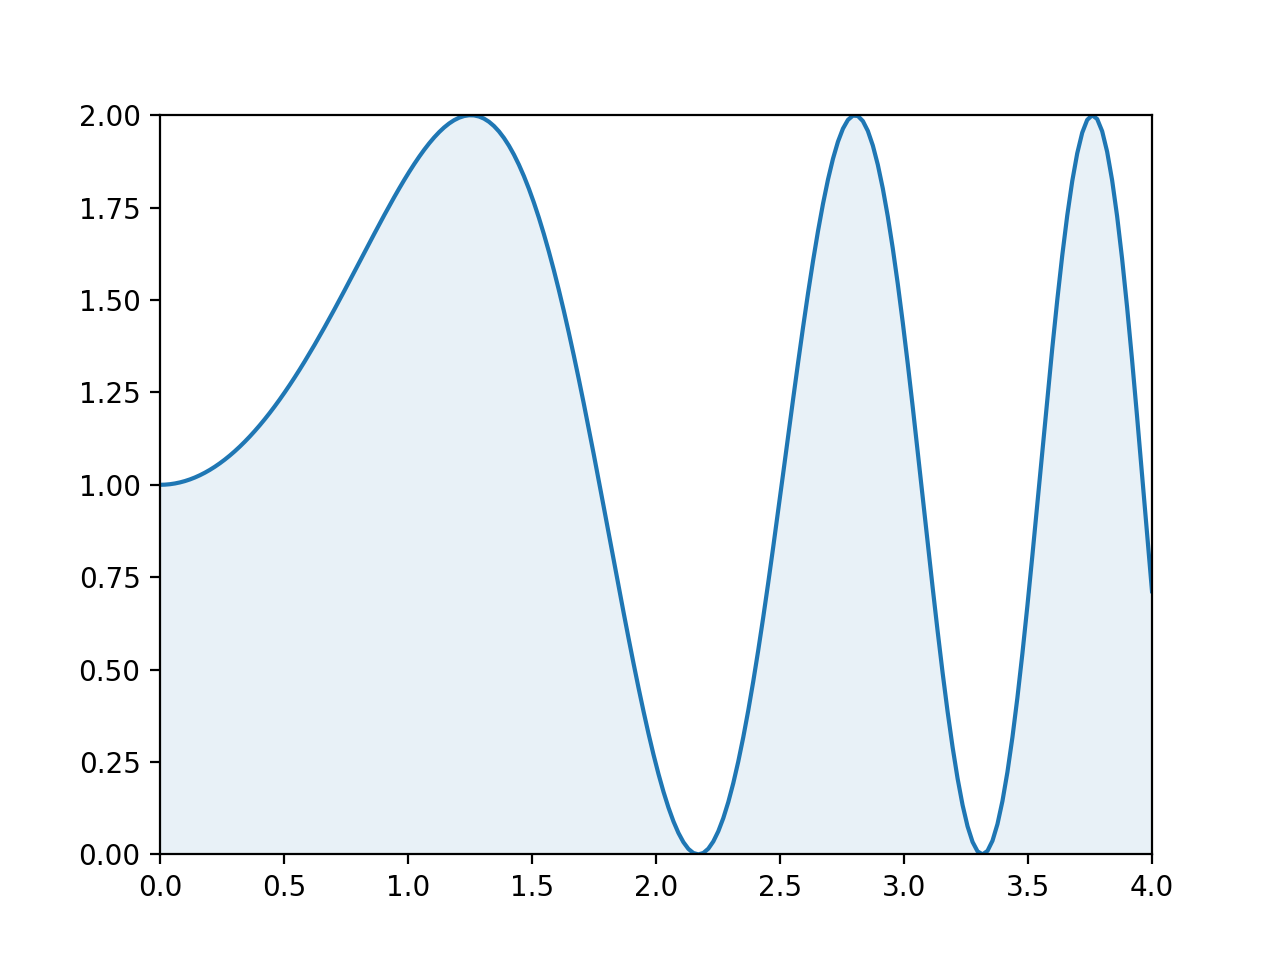

In [5]:
def pdf(x):
    return np.sin(x**2) + 1

xs = np.linspace(0, 4, 200)
ps = pdf(xs)
plt.plot(xs, ps)
plt.fill_between(xs, 0, ps, alpha=0.1)
plt.xlim(0, 4)
plt.ylim(0, 2);

<IPython.core.display.Javascript object>


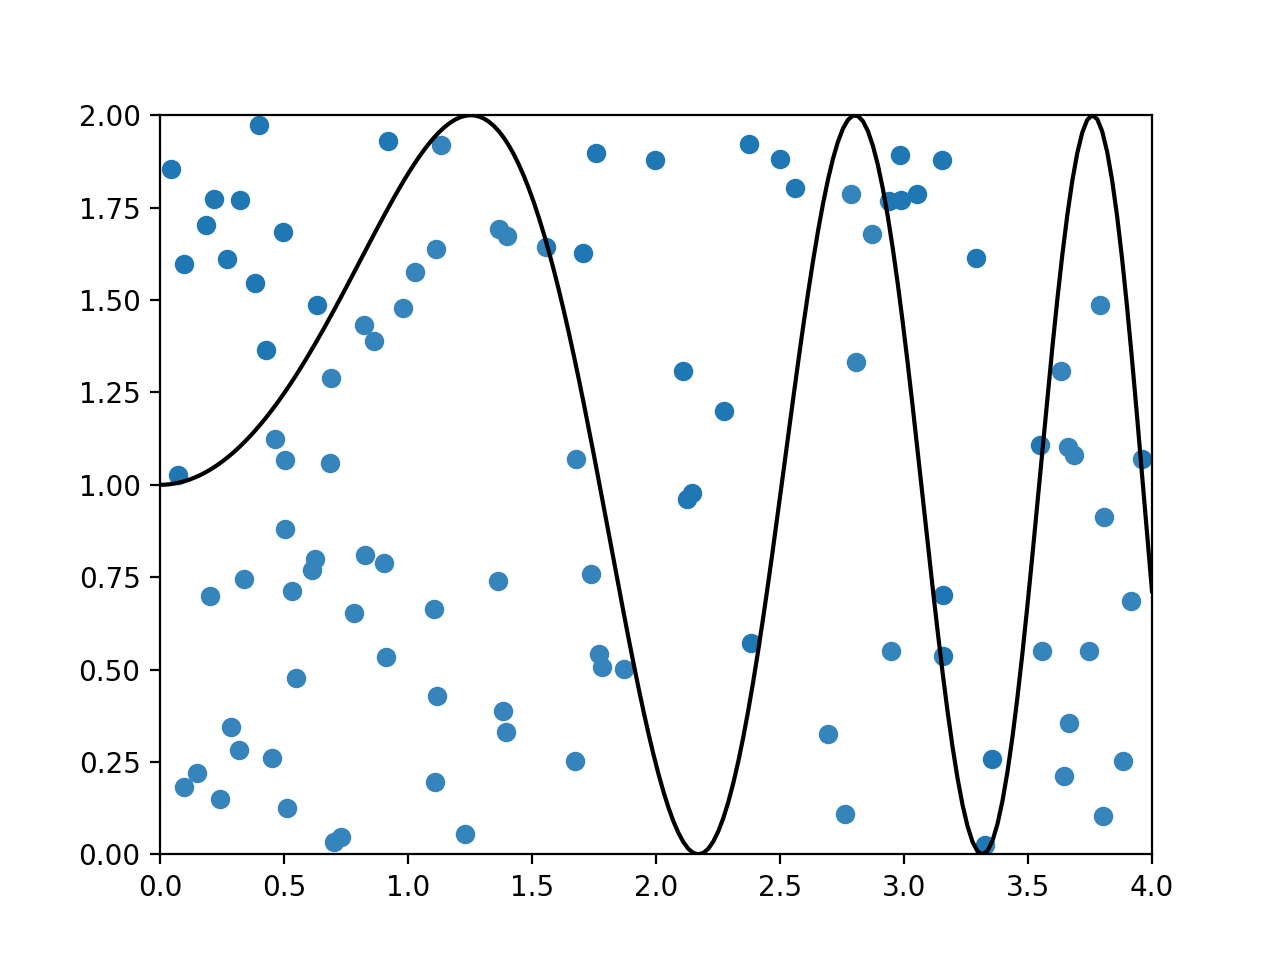

In [6]:
n = 100
random_x = uniform.rvs(loc=0, scale=4, size=n)
random_y = uniform.rvs(loc=0, scale=2, size=n)

plt.scatter(random_x, random_y)
plt.plot(xs, ps, c="k")
plt.fill_between(xs, 0, ps, color="w", alpha=0.1)
plt.xlim(0, 4), plt.ylim(0, 2);

<IPython.core.display.Javascript object>


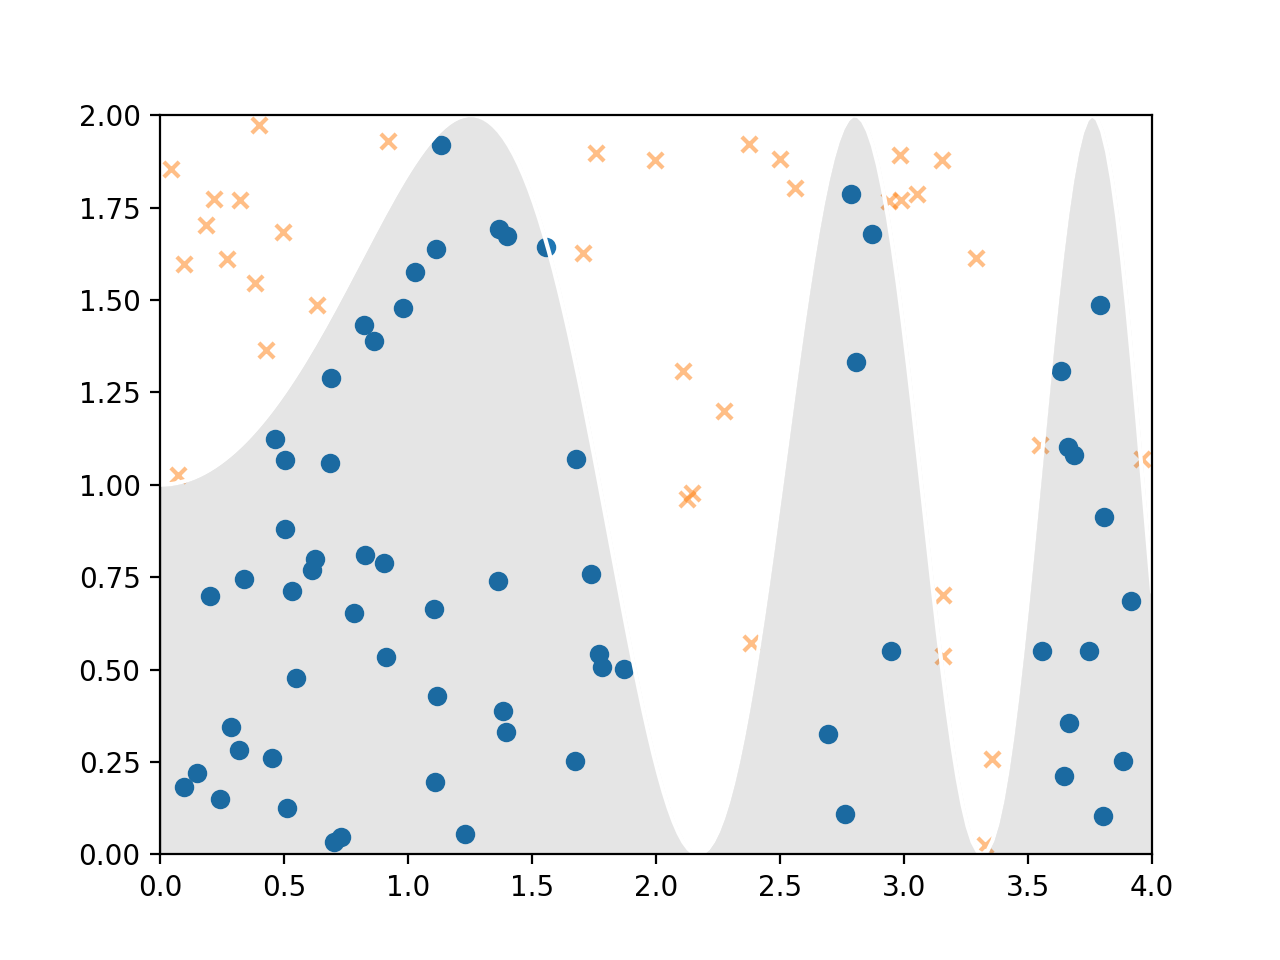

In [7]:
passed = random_y <= pdf(random_x)
plt.scatter(random_x[passed], random_y[passed])
plt.scatter(random_x[~passed], random_y[~passed], marker="x", s=30, alpha=0.5)
plt.plot(xs, ps, c="w")
plt.fill_between(xs, 0, ps, color="k", alpha=0.1)
plt.xlim(0, 4), plt.ylim(0, 2);

59451


<IPython.core.display.Javascript object>


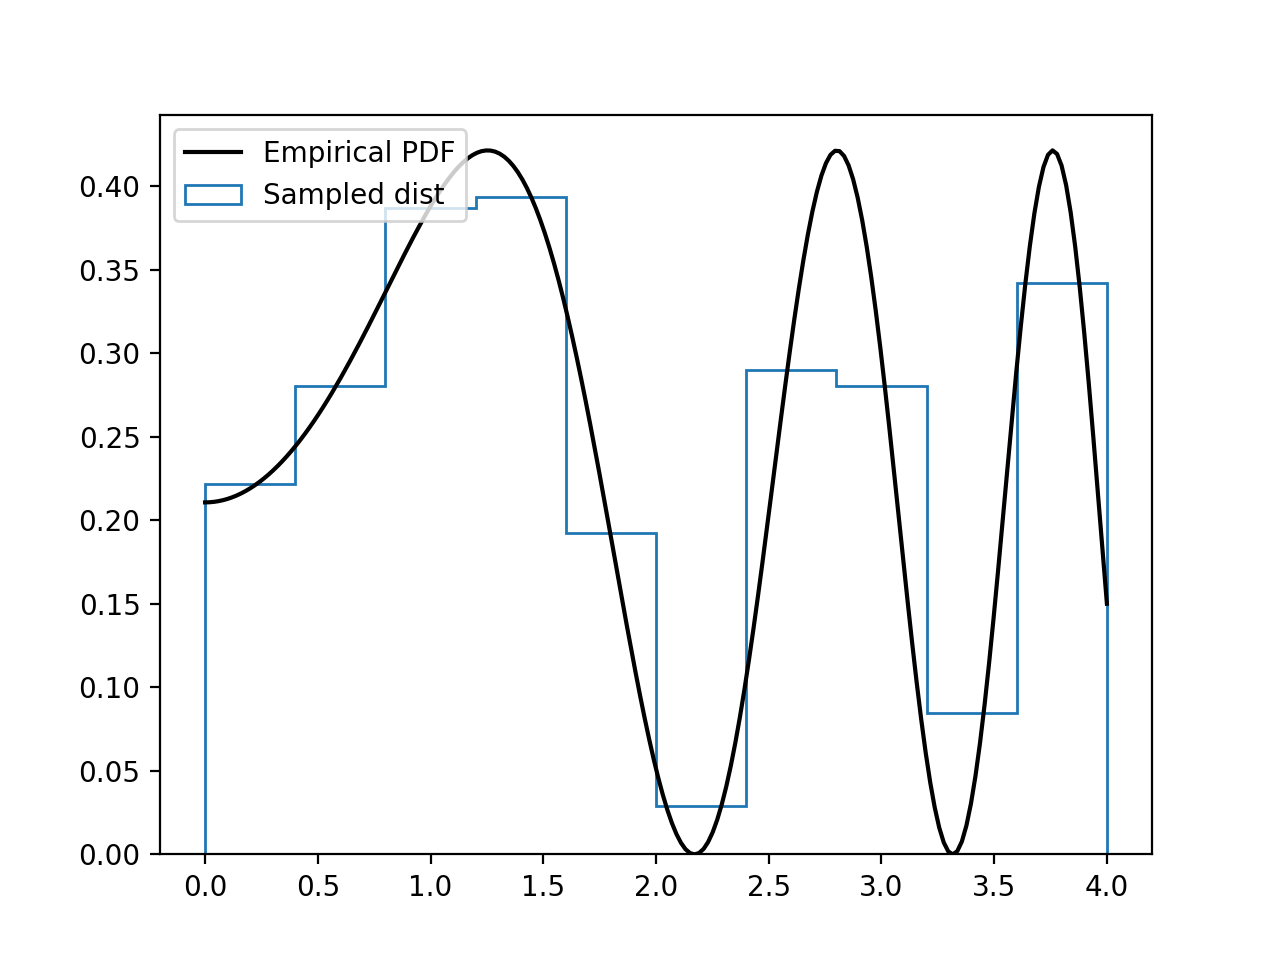

In [8]:
n2 = 100000
x_test = uniform.rvs(scale=4, size=n2)
x_final = x_test[uniform.rvs(scale=2, size=n2) <= pdf(x_test)]
print(len(x_final))
from scipy.integrate import simps
plt.hist(x_final, density=True, histtype="step", label="Sampled dist")
plt.plot(xs, ps / simps(ps, x=xs), c="k", label="Empirical PDF")
plt.legend(loc=2);

### Inversion Sampling

This is harder to conceptually understand. But the way I can put it the simplest is that we know that, for all PDFs, the CDF is going to go from 0 to 1. If we can uniformly sample the CDF from 0 to 1, can we invert our function so that we can recover the $x$ value that gives the sampled CDF value? For some functions, yes. For some, no, the math isn't solvable.

The function above is tricky, so let's find a function that's simpler to sample.

Let's say our new PDF is $p(x) = 3 x^2$ from $0 \rightarrow 1$. As opposed to the previous function, this one is normalised.

So, we can find the CDF via

$$ CDF(x) = \int_0^x p(x^\prime) dx^\prime = x^3 $$

Once we have the CDF, we want to invert it. That is, at the moment, we have an $x$ value and get a $y$ value - the CDF. We want to give it a CDF and get the $x$ value:

$$ y = x^3 \rightarrow x = y^3 $$

Which means $y = x^{1/3}$. Or to put the CDF syntax back in, $x = CDF^{1/3}$

In [9]:
def pdf(x):
    return 3 * x**2
def cdf(x):
    return x**3
def icdf(cdf):
    return cdf**(1/3)

<IPython.core.display.Javascript object>


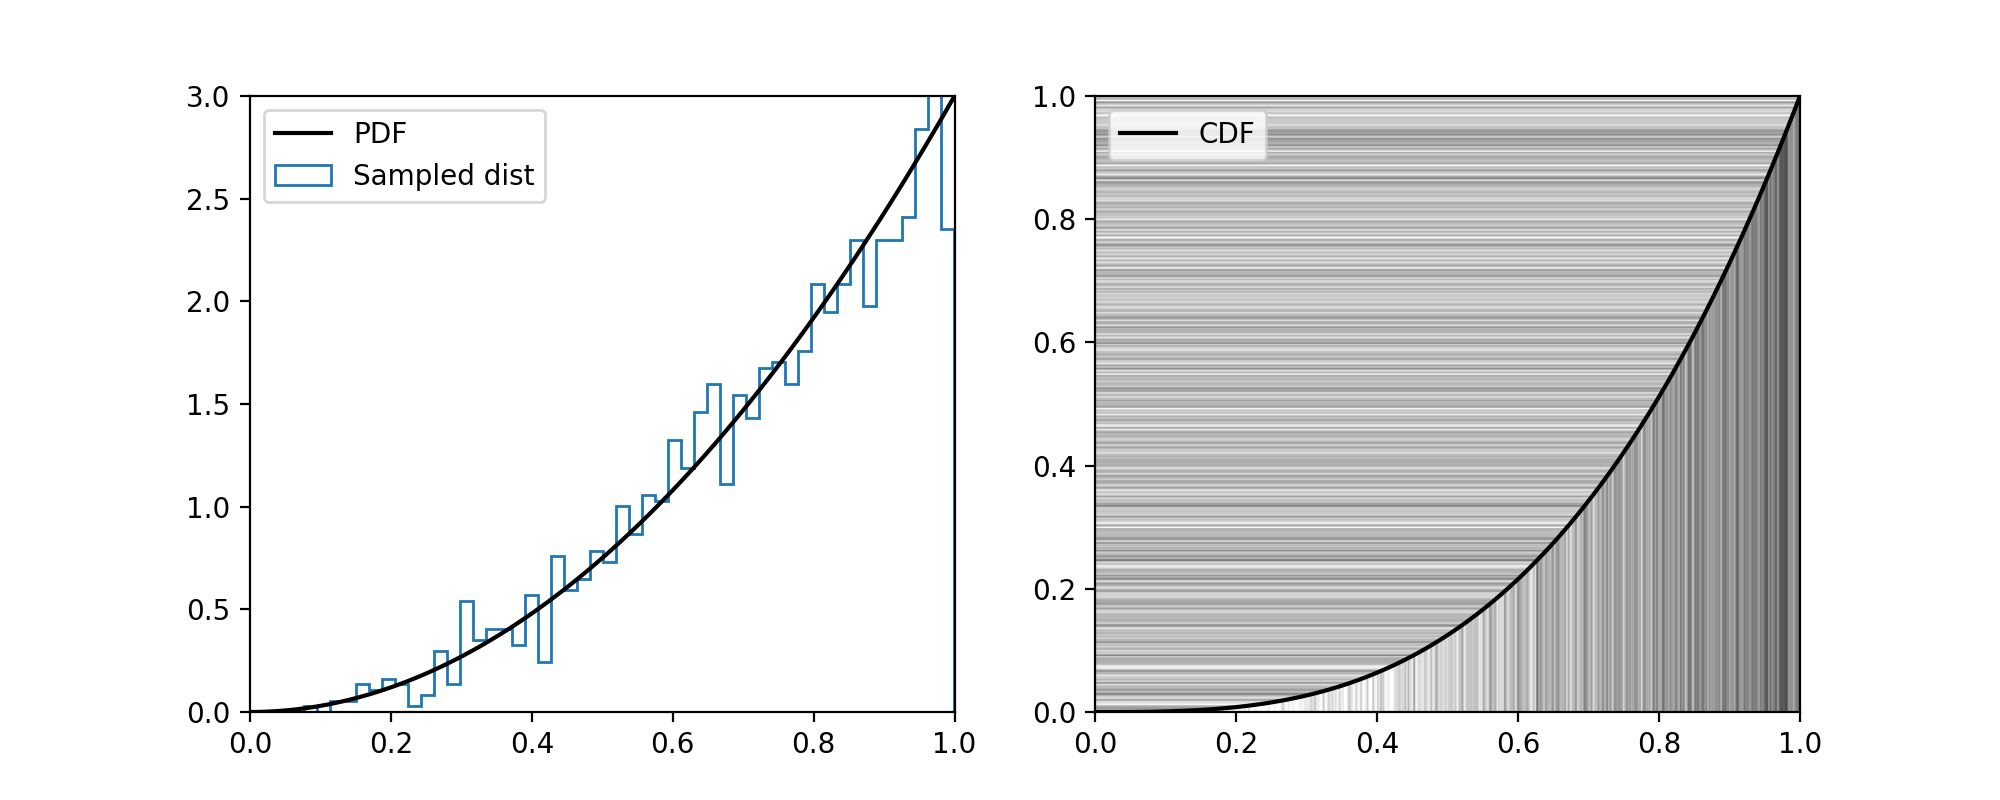

In [11]:
xs = np.linspace(0, 1, 100)
pdfs = pdf(xs)
cdfs = cdf(xs)
n = 2000
u_samps = uniform.rvs(size=n)
x_samps = icdf(u_samps)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
axes[0].plot(xs, pdfs, color="k", label="PDF")
axes[0].hist(x_samps, density=True, histtype="step", label="Sampled dist", bins=50)

axes[1].plot(xs, cdfs, color="k", label="CDF")

axes[1].hlines(u_samps, 0, x_samps, linewidth=0.1, alpha=0.3)
axes[1].vlines(x_samps, 0, u_samps, linewidth=0.1, alpha=0.3)

axes[0].legend(), axes[1].legend()

axes[1].set_xlim(0, 1), axes[1].set_ylim(0, 1);
axes[0].set_xlim(0, 1), axes[0].set_ylim(0, 3);

Of course, we don't actually have to do the maths ourselves! So long as we have the PDF, we can numrically get the CDF and invert it.

<IPython.core.display.Javascript object>


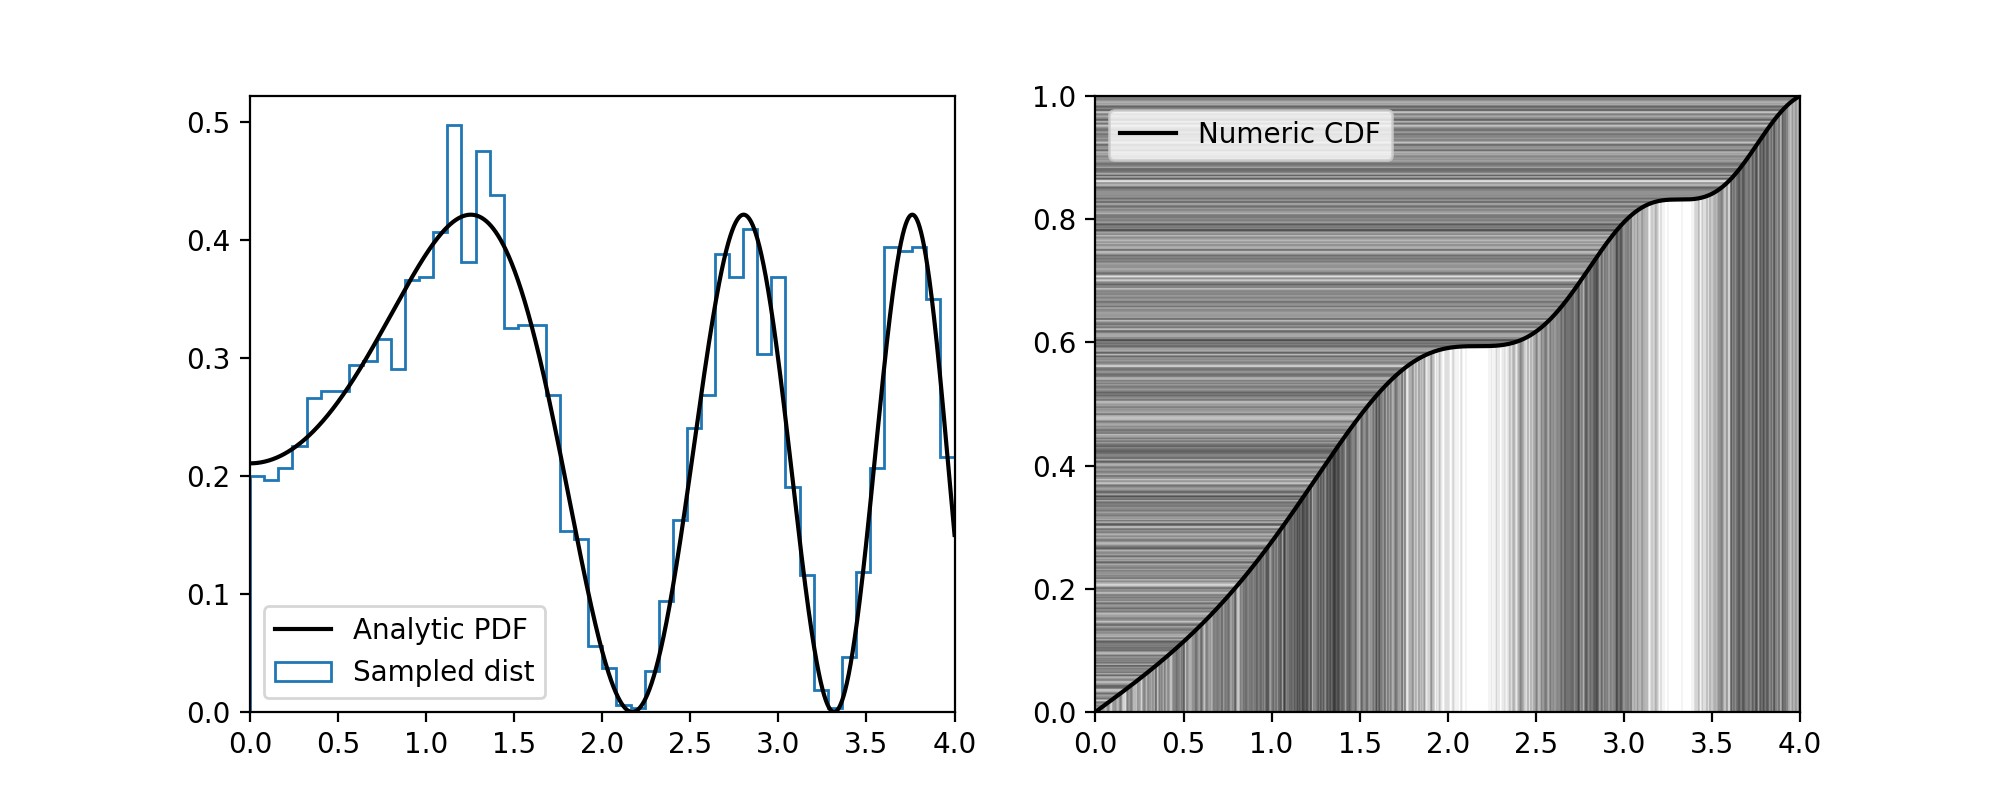

In [13]:
from scipy.interpolate import interp1d

def pdf(x):
    return np.sin(x**2) + 1
xs = np.linspace(0, 4, 10000)
pdfs = pdf(xs)
cdfs = pdfs.cumsum() / pdfs.sum()  # Dangerous

u_samps = uniform.rvs(size=4000)
x_samps = interp1d(cdfs, xs)(u_samps)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].hist(x_samps, density=True, histtype="step", label="Sampled dist", bins=50)
axes[0].plot(xs, pdfs/4.747, color="k", label="Analytic PDF")
axes[0].legend(loc=3), axes[0].set_xlim(0, 4)
axes[1].plot(xs, cdfs, color="k", label="Numeric CDF")
axes[1].hlines(u_samps, 0, x_samps, linewidth=0.1, alpha=0.3)
axes[1].vlines(x_samps, 0, u_samps, linewidth=0.1, alpha=0.3)
axes[1].legend(loc=2), axes[1].set_xlim(0, 4), axes[1].set_ylim(0, 1);